# First Attempt at Feature Engineering

In [2]:
import pandas as pd
import numpy as np

## Importing the Data
All this data was retrieved from INSEE 2020 and 2015 official data sets
Steps:

- Import data
- Rotate to get a synthetic "OneHotEncoded" table


In [3]:
#Get the initial data
df = pd.read_csv('DataFrance/equipment.csv', sep=';')
liste= ("A203","A206","A401","A101","A406","A405", "A5", "B", "F")
df = df[df.TYPEQU.str.startswith(liste)]
#df6=df[df.TYPEQU.str.startswith('B')== True]
df6=df
df6 = df6[['TYPEQU','DEPCOM','PRES_2020','PRES_2015']]
df6.drop(columns='PRES_2020', inplace= True)
df6 = df6.pivot_table(values='PRES_2015', index=df.DEPCOM, columns='TYPEQU', aggfunc='first').reset_index(drop=False).dropna()

/home/julienlefebvre/.pyenv/versions/3.8.6/envs/Housing/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (1,2,3,4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/julienlefebvre/.pyenv/versions/3.8.6/envs/Housing/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Redefining the Category Labels

Objectives:
- Select only desired Variables
- Aggregate columns from same type group to get the sums of 'equipment' per commune

In [4]:
#Rename Columns with the respective columns only
categories = set(["A2","A4","A1", "A5", "B", "F"])

def correct_categories(cols):
    return [cat for col in cols for cat in categories if col.startswith(cat)]    

names = correct_categories(df6.columns)
names.insert(0,'DEPCOM')
df6.columns = names

#Format and Sun up  of features into their categories
df7 = df6.drop(columns='DEPCOM').astype('int')
df7 =df7.groupby(df7.columns, axis=1).agg(np.sum)
df7.insert(0,'DEPCOM',df6.DEPCOM)
df7.head(10)

,DEPCOM,A1,A2,A4,A5,B,F
0,1001,0,0,1,2,1,4
1,1002,0,0,0,0,0,0
2,1004,0,2,3,7,19,14
3,1005,0,2,1,4,3,6
4,1006,0,0,0,0,0,0
5,1007,0,1,2,5,4,5
6,1008,0,0,2,3,2,5
7,1009,0,0,0,1,0,0
8,1010,0,0,3,2,3,4
9,1011,0,0,0,1,0,0


In [5]:
# Category definition grouping

#100 as large surfaces
#200 as groceries
#300
#400
#500

# Import Prices Dataset and Merge with Feature frame

- Retrieve data from online database
- visualize a bit

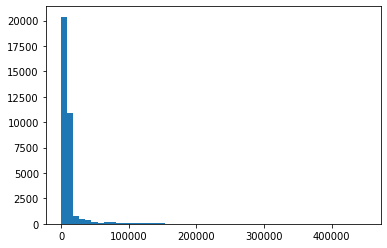

,A1,A2,A4,A5,B,F,Price,nombre_lots,nombre_pieces_principales
count,34071.0,34071.0,34071.0,34071.0,34071.000000,34071.000000,34071.000000,34071.000000,34071.000000
mean,1.0,2.0,3.0,7.0,21.409322,12.746852,12859.135423,1.624813,2.365413
std,0.0,0.0,0.0,0.0,0.629935,2.767116,21939.654730,0.863862,1.280554
min,1.0,2.0,3.0,7.0,20.000000,5.000000,45.000000,0.000000,0.000000
25%,1.0,2.0,3.0,7.0,21.000000,12.000000,7067.000000,1.000000,1.000000
50%,1.0,2.0,3.0,7.0,21.000000,13.000000,8463.000000,2.000000,2.000000
75%,1.0,2.0,3.0,7.0,22.000000,14.000000,10333.000000,2.000000,3.000000
max,1.0,2.0,3.0,7.0,22.000000,17.000000,450000.000000,27.000000,18.000000


In [8]:
#Load Libraries and Create engine Connection
#Load Libraries and Create engine Connection

import pymysql
import pandas as pd
import numpy as np
import sqlalchemy
import gc
engine =sqlalchemy.create_engine(
        sqlalchemy.engine.url.URL.create(
        drivername="mysql+pymysql",
        username='Estimators',  # e.g. "my-database-user"
        password='Estimator2021',  # e.g. "my-database-password"
        host='34.77.88.127',  # e.g. "127.0.0.1"
        port=3306,  # e.g. 3306
        database='Housing_France',  # e.g. "my-database-name"
    ))

conn = engine.connect().execution_options(stream_results=True)    

def get_data(querystring,chunk):
    engine =sqlalchemy.create_engine(
    sqlalchemy.engine.url.URL.create(
    drivername="mysql+pymysql",
    username='Estimators',  # e.g. "my-database-user"
    password='Estimator2021',  # e.g. "my-database-password"
    host='34.77.88.127',  # e.g. "127.0.0.1"
    port=3306,  # e.g. 3306
    database='Housing_France',  # e.g. "my-database-name"
    ))
    conn = engine.connect().execution_options(stream_results=True)
    frame = pd.DataFrame()
    for chunk_dataframe in pd.read_sql(
            querystring, conn, chunksize=chunk):
            #print(f"Got dataframe w/{len(chunk_dataframe)} rows")
            frame= frame.append(chunk_dataframe)

            # ... do something with dataframe ...
            
    return frame
import matplotlib.pyplot as plt
querystring = """SELECT code_commune, ROUND(dwu.valeur_fonciere/dwu.surface_reelle_bati,0) as Price, dwu.nombre_lots,dwu.nombre_pieces_principales FROM data_working_update dwu
WHERE year(dwu.date_mutation) = 2016
AND dwu.type_local = 'Appartement'
AND dwu.code_departement = 75
;"""
#Get Data
df8 = get_data(querystring, 1000)

#Visualize a bit
plt.hist(df8.Price, bins=50)
plt.show()

#Merge prices query with featured dataset
merged = df7.merge(df8, left_on='DEPCOM', right_on='code_commune' ,how='inner').drop(columns='code_commune')
merged.describe()

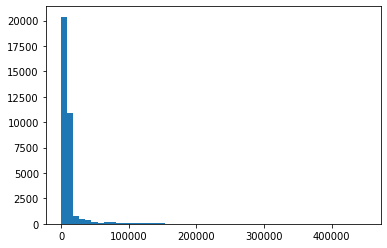

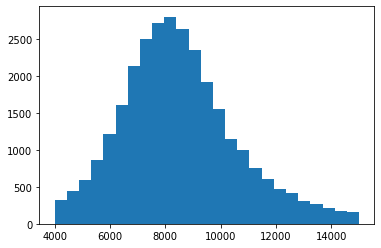

In [7]:
#Remove annoying outliers
merged= merged[merged.Price.between(4000,15000)]
plt.hist(merged.Price, bins=25)
plt.show()

# First Prediction Models
- Preprocessing
- linear models
- Xgboost

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression , Ridge , Lasso
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as rmse
model = Lasso()
X = merged.drop(columns=['DEPCOM','Price'])
y = merged.Price

In [10]:
#Performing normal train test split on the formatted data (both X and target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

#Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Defining our PCA model and converting our data into components
pca_model = PCA(n_components=5)
converted = pca_model.fit(X)
X = converted.transform(X)

#Fit with Regular Regression Models
fitter = model.fit(X_train,y_train)
print(f"{model} R2 score is: {np.round(model.score(X_test, y_test),3)})")
print(f"{model} rmse score is: {np.round(rmse(model.predict(X_test),y_test),3)})")
print(f"{model} mape score is: {np.round(mape(model.predict(X_test),y_test),3)}"  )  

Lasso() R2 score is: 0.052)
Lasso() rmse score is: 447804580.304)
Lasso() mape score is: 1.036


In [12]:
#Checking the result with a standard xgboost

from xgboost import XGBRegressor as xgb
model = xgb(learning_rate = .1)
model = model.fit(X_train, y_train)
fitter = model.fit(X_train,y_train)
print(f" R2 score is: {np.round(model.score(X_test, y_test),3)})")
print(f"rmse score is: {np.round(rmse(model.predict(X_test),y_test),3)})")
print(f" mape score is: {np.round(mape(model.predict(X_test),y_test),3)}"  )  

 R2 score is: 0.458)
rmse score is: 255864165.083)
 mape score is: 0.385
